### Preamble

In [1]:
# Configure libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
import geohash
from sklearn.metrics import mean_squared_error

###  Reading the data

In [2]:
# Each line is of the format:
# ((time_cat, time_num, time_cos, time_sin, day_cat, day_num, day_cos, day_sin, weekend, geohash), number of pickups)
names = ["time_cat", "time_num", "time_cos", "time_sin", "day_cat", "day_num", "day_cos", "day_sin", "weekend", "geohash", "pickups"]
dftaxi=pd.read_csv("./data/taxi_data.csv", header=None, names = names)
print dftaxi.shape

# n = 50000
# dftaxi = dftaxi.head(n)
dftaxi.head()

(312330, 11)


,time_cat,time_num,time_cos,time_sin,day_cat,day_num,day_cos,day_sin,weekend,geohash,pickups
0,22:00,0.937500,0.923880,-0.382683,Monday,0.133929,0.666347,0.745642,0,dr5rst,5476
1,22:00,0.937500,0.923880,-0.382683,Monday,0.133929,0.666347,0.745642,0,dr5xep,3
2,02:00,0.104167,0.793353,0.608761,Wednesday,0.300595,-0.312572,0.949894,0,dr5rek,18
3,05:00,0.229167,0.130526,0.991445,Thursday,0.461310,-0.970597,0.240712,0,dr72qr,54
4,08:00,0.354167,-0.608761,0.793353,Tuesday,0.193452,0.347871,0.937542,0,dr70jn,2


### Decode geohashes to filter for pickups near JFK

In [3]:
# Get the longitude and latitude from the geohash
def decodegeo(geo, which):
    if len(geo) == 6:
        geodecoded = geohash.decode(geo)
        return geodecoded[which]
    else:
        return 0
dftaxi['latitude'] = dftaxi['geohash'].apply(lambda geo: decodegeo(geo, 0))
dftaxi['longitude'] = dftaxi['geohash'].apply(lambda geo: decodegeo(geo, 1))

In [4]:
dftaxi.head()

,time_cat,time_num,time_cos,time_sin,day_cat,day_num,day_cos,day_sin,weekend,geohash,pickups,latitude,longitude
0,22:00,0.937500,0.923880,-0.382683,Monday,0.133929,0.666347,0.745642,0,dr5rst,5476,40.723572,-73.976440
1,22:00,0.937500,0.923880,-0.382683,Monday,0.133929,0.666347,0.745642,0,dr5xep,3,40.734558,-73.690796
2,02:00,0.104167,0.793353,0.608761,Wednesday,0.300595,-0.312572,0.949894,0,dr5rek,18,40.718079,-74.031372
3,05:00,0.229167,0.130526,0.991445,Thursday,0.461310,-0.970597,0.240712,0,dr72qr,54,40.866394,-73.899536
4,08:00,0.354167,-0.608761,0.793353,Tuesday,0.193452,0.347871,0.937542,0,dr70jn,2,40.816956,-74.306030


### Create a latitude/longitude perimeter around JFK Airport

Latitude: 40.665015 | Longitude: -73.835903

Latitude: 40.666056 | Longitude: -73.739086

Latitude: 40.622813 | Longitude: -73.739086

Latitude: 40.622813 | Longitude: -73.835903


In [5]:
lat_range = [40.622813, 40.666056]
long_range = [-73.835903, -73.739086]
# Filter by latitude
jfk_taxidf = dftaxi[dftaxi['latitude'] >= lat_range[0]]
jfk_taxidf = jfk_taxidf[jfk_taxidf['latitude'] <= lat_range[1]]
# Filter by longitude
jfk_taxidf = jfk_taxidf[jfk_taxidf['longitude'] >= long_range[0]]
jfk_taxidf = jfk_taxidf[jfk_taxidf['longitude'] <= long_range[1]]
print "Number of taxi pickups from JFK: {}".format(len(jfk_taxidf))

Number of taxi pickups from JFK: 6258


### Transform dataframe to get desired columns

In [24]:
jfk_total_pickups_by_time_day = pd.DataFrame(group_by_day['pickups'].aggregate(np.sum).reset_index())
total_pickups = jfk_total_pickups_by_time_day['pickups'].sum()
print "Total pickups at JFK: {}".format(total_pickups)
jfk_total_pickups_by_time_day.head()

Total pickups at JFK: 7195396


,day_cat,time_cat,pickups
0,Friday,00:00,46141
1,Friday,01:00,21854
2,Friday,02:00,6420
3,Friday,03:00,2658
4,Friday,04:00,3695


In [79]:
def cleanup_axes(ax):
    #helper function to clean up axes
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
current_palette = sns.color_palette("dark")+sns.color_palette("colorblind")

### Prep data for plotting

In [72]:
# Key are day, value is a list of number of pickups for each hour
pickups_by_day = {}
times = np.arange(0,24,1)
days = set(jfk_total_pickups_by_time_day['day_cat'].values)
for day in days:
    pickups_by_day[day] = jfk_total_pickups_by_time_day[jfk_total_pickups_by_time_day['day_cat'] == day]['pickups'].values

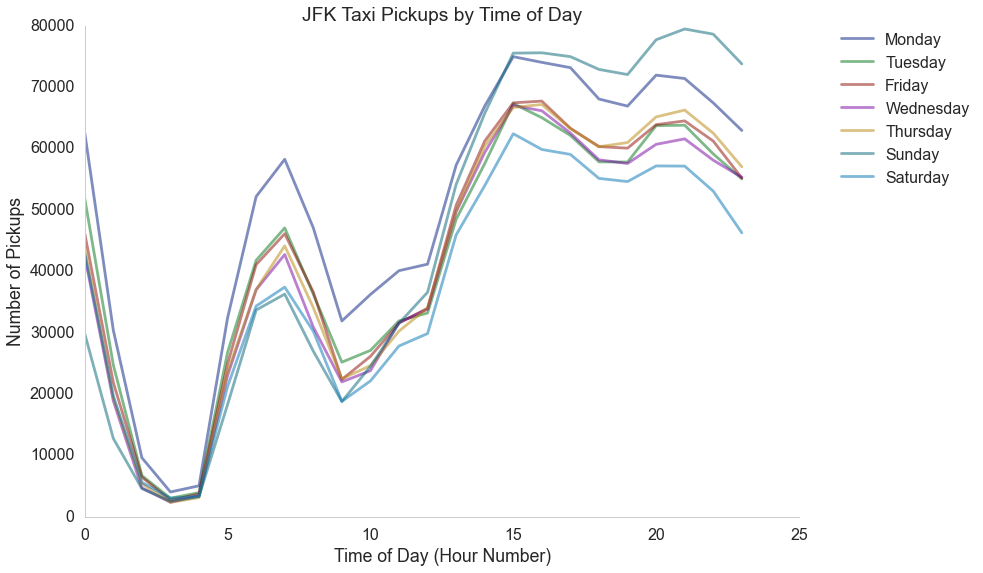

In [80]:
color_idx = 0
for day in days:
    plt.plot(times,pickups_by_day[day],color=current_palette[color_idx],alpha=0.5,axes=ax,label=day)
    color_idx += 1
ax = plt.axes()
#plt.plot(times,pickups,color=current_palette[0],alpha=0.5,axes=ax)
plt.title('JFK Taxi Pickups by Time of Day')
plt.xlabel('Time of Day (Hour Number)')
plt.ylabel('Number of Pickups')
cleanup_axes(ax)
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)